# Problem Statement:
#### Predict the wind speed for next 6 hours based on the historical wind speed data present in atlantic hurricane database using time series forecasting models "LSTM and GRU".

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.

A Gated Recurrent Unit (GRU), as its name suggests, is a variant of the RNN architecture, and uses gating mechanisms to control and manage the flow of information between cells in the neural network.

RNN’s are good for processing sequence data for predictions but suffers from short-term memory. LSTM’s and GRU’s were created as a method to mitigate short-term memory using mechanisms called gates.

Import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime, date, time
from matplotlib import pyplot
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import  GRU
import tensorflow as tf
dataset = pd.read_csv("data/hur.csv",
                   parse_dates={'dt' : ["date_time"]},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
dataset.drop(columns  = ['Year_','Year','Minutes_in_UTC',
                         'Month','Day','Basin', 'Minimum_Pressure_in_millibars',
                         'ATCF_cyclone_number_for_that_year', 'Name', 'Record_identifier','Record_identifier_desc', 'Status_of_system','Status_of_system_desc'],
                         inplace = True)
dataset.drop(columns = 'Unnamed: 0', inplace = True)


It is a good idea to fix the random number seed to ensure our results are reproducible.

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

Extracting the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [4]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3
0,0.000000,0.281843,0.085217,0.67803
1,0.260870,0.281843,0.081739,0.67803
2,0.521739,0.281843,0.078261,0.67803
3,0.782609,0.283198,0.075362,0.67803


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the windspped at a given time (t) and Y is the windspeed at the 
next time (t + 1).

In [6]:
# convert an array of values into a dataset matrix
def create_ts_data(dataset, lookback=1, predicted_col=3):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    return final_df
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,3)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
id                                                       
1    0.000000   0.281843   0.085217    0.67803    0.67803
2    0.260870   0.281843   0.081739    0.67803    0.67803
3    0.521739   0.281843   0.078261    0.67803    0.67803
4    0.782609   0.283198   0.075362    0.67803    0.67803


With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 70% of the observations that we can use to train our model, leaving the remaining 30% for testing the model.

In [7]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35637, 1, 4) (35637,) (15273, 1, 4) (15273,)


# Creating LSTM & GRU Network

After data preparation we will design and fit our LSTM and GRU network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [8]:
# create and fit the LSTM network
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')


In [9]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 75)             24000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             12720     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 44,071
Trainable params: 44,071
Non-trainable params: 0
_________________________________________________________________


After Creating model now we will fit the network to our problem

In [10]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/30
557/557 [==============================] - 7s 12ms/step - loss: 0.0761 - val_loss: 0.0167
Epoch 2/30
557/557 [==============================] - 5s 9ms/step - loss: 0.0175 - val_loss: 0.0160
Epoch 3/30
557/557 [==============================] - 5s 9ms/step - loss: 0.0173 - val_loss: 0.0167
Epoch 4/30
557/557 [==============================] - 5s 8ms/step - loss: 0.0171 - val_loss: 0.0149
Epoch 5/30
557/557 [==============================] - 4s 8ms/step - loss: 0.0170 - val_loss: 0.0150
Epoch 6/30
557/557 [==============================] - 4s 8ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 7/30
557/557 [==============================] - 5s 9ms/step - loss: 0.0163 - val_loss: 0.0152
Epoch 8/30
557/557 [==============================] - 5s 8ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 9/30
557/557 [==============================] - 4s 8ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 10/30
557/557 [==============================] - 5s 8ms/step - loss: 0.0162 - val_loss: 0.016

After the model was fit, we estimated the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

The predictions were inverted before calculating error scores to ensure that performance is reported in the same units as the original data.

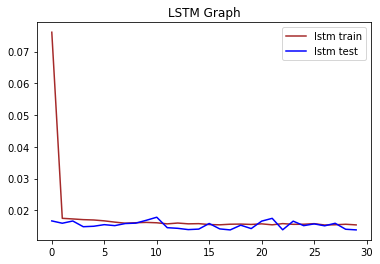

In [11]:
# make lstm predictions
pred_y =  model_lstm.predict(test_X)
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.title("LSTM Graph")
pyplot.show()

In [12]:
test_y.reshape(15273,1)

array([[0.50757575],
       [0.54545456],
       [0.56439394],
       ...,
       [0.54545456],
       [0.5265151 ],
       [0.5265151 ]], dtype=float32)

In [13]:
pred_y

array([[0.46973026],
       [0.50993115],
       [0.54747814],
       ...,
       [0.55575776],
       [0.53839844],
       [0.5198474 ]], dtype=float32)

## GRU Network Model

In [14]:
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 75)             18225     
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 30)             9630      
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 33,466
Trainable params: 33,466
Non-trainable params: 0
_________________________________________________________________


In [15]:
# fit network
gru_history = model_gru.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/30
557/557 [==============================] - 7s 13ms/step - loss: 0.0524 - val_loss: 0.0151
Epoch 2/30
557/557 [==============================] - 5s 9ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 3/30
557/557 [==============================] - 5s 9ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 4/30
557/557 [==============================] - 5s 8ms/step - loss: 0.0170 - val_loss: 0.0153
Epoch 5/30
557/557 [==============================] - 4s 8ms/step - loss: 0.0170 - val_loss: 0.0144
Epoch 6/30
557/557 [==============================] - 4s 8ms/step - loss: 0.0161 - val_loss: 0.0181
Epoch 7/30
557/557 [==============================] - 5s 8ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 8/30
557/557 [==============================] - 4s 7ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 9/30
557/557 [==============================] - 5s 8ms/step - loss: 0.0164 - val_loss: 0.0180
Epoch 10/30
557/557 [==============================] - 4s 8ms/step - loss: 0.0167 - val_loss: 0.015

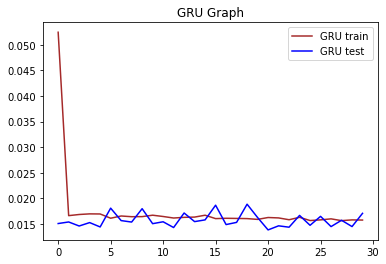

In [16]:
pred_gru_y =  model_gru.predict(test_X)
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
pyplot.legend()
pyplot.title("GRU Graph")
pyplot.show()

In [17]:
test_y.reshape(15273,1)

array([[0.50757575],
       [0.54545456],
       [0.56439394],
       ...,
       [0.54545456],
       [0.5265151 ],
       [0.5265151 ]], dtype=float32)

In [18]:
pred_gru_y

array([[0.4783234 ],
       [0.51670307],
       [0.5554313 ],
       ...,
       [0.564122  ],
       [0.5483471 ],
       [0.529385  ]], dtype=float32)

Comparison of Graphs and numerical values of windspeed predicted by LSTM and GRU shows that LSTM works better in this case var loss is very less in case of LSTM.

# Visualizing and Comparing LSTM & GRU Network Predictions

Now we will make predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

LSTM MSE:  0.000594      GRU MSE:  0.000672
LSTM R2:  0.936805        GRU R2:  0.928568
LSTM RMSE:  0.024375    GRU RMSE:  0.025915
LSTM MAE:  0.013884      GRU MAE:  0.017076


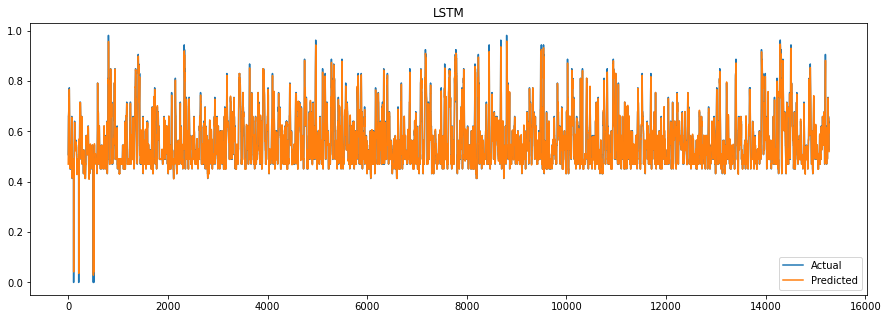

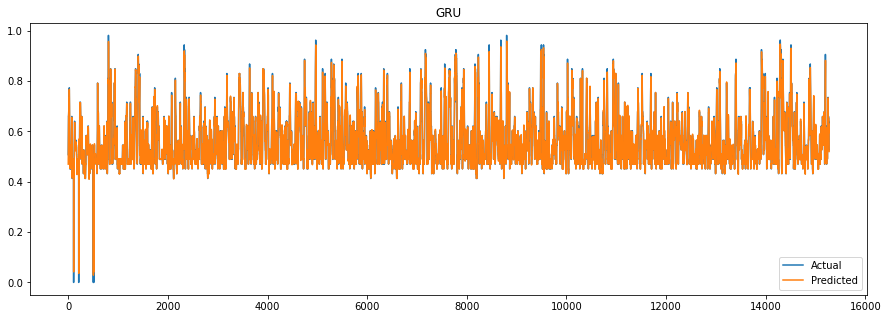

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt
#LSTM RMSE
MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)
# GRU RMSE
MSE_gru = mean_squared_error(test_y, pred_gru_y)
R2_Gru = r2_score(test_y, pred_gru_y)
RMSE_gru = sqrt(mean_squared_error(test_y, pred_gru_y))
MAE_gru = mean_absolute_error(test_y, pred_gru_y)


print("LSTM MSE: ",round(MSE,6),"     GRU MSE: ",round(MSE_gru,6))
print("LSTM R2: ",round(R2,6),"       GRU R2: ",round(R2_Gru,6))
print("LSTM RMSE: ",round(RMSE,6),"   GRU RMSE: ",round(RMSE_gru,6))
print("LSTM MAE: ",round(MAE,6),"     GRU MAE: ",round(MAE_gru,6))


#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.title("LSTM")
plt.show()
#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.title("GRU")
plt.show()

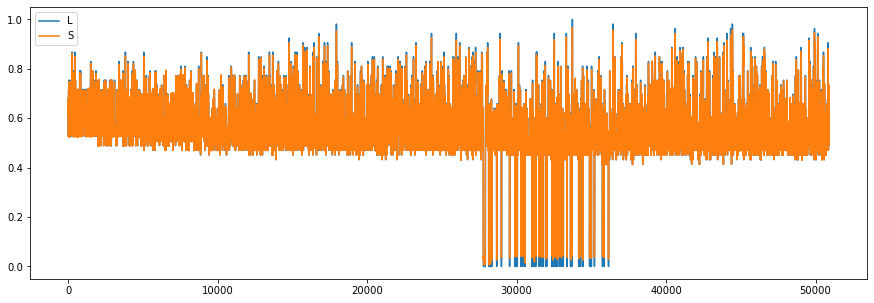

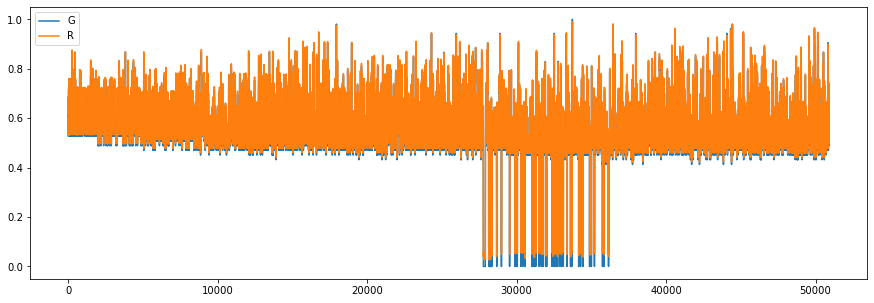

In [23]:
#LSTM visualization over full data
tra_lstm = np.concatenate([train_X,test_X])
tes_lstm = np.concatenate([train_y,test_y])
fp_lstm = model_lstm.predict(tra_lstm)
plt.plot(tes_lstm, label = 'Actual')
plt.plot(fp_lstm, label = 'Predicted')
plt.legend("LSTM Full data Visualization")
plt.show()
#GRU visualization over full data
tra_gru = np.concatenate([train_X,test_X])
tes_Gru = np.concatenate([train_y,test_y])
fp_gru = model_gru.predict(tra_gru)
plt.plot(tes_Gru, label = 'Actual')
plt.plot(fp_gru, label = 'Predicted')
plt.legend()
plt.legend("GRU Full data Visualization")
plt.show()

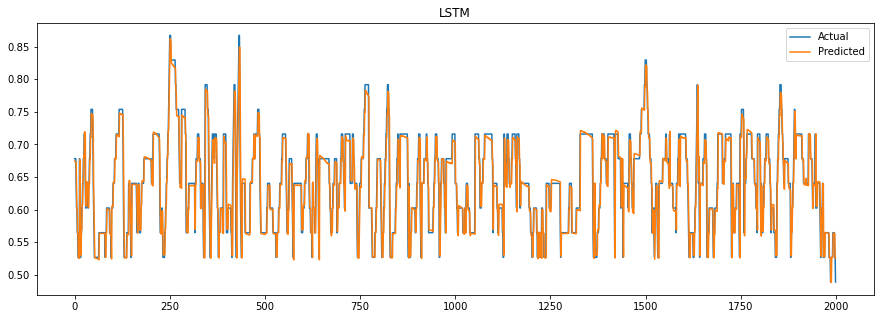

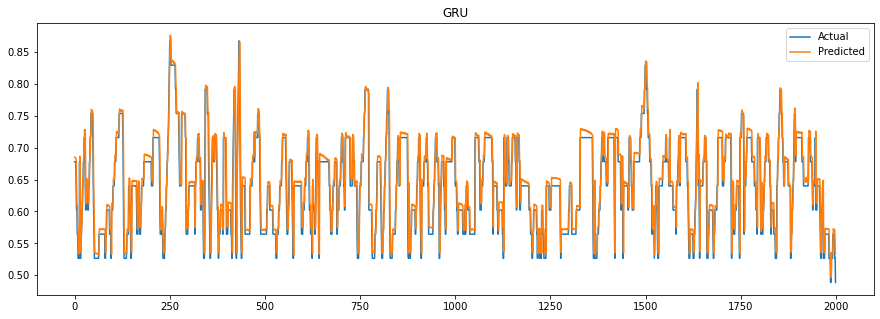

In [24]:
#LSTM over small part of data
plt.plot(tes_lstm[:2000], label = 'Actual')
plt.plot(fp_lstm[:2000], label = 'Predicted')
plt.legend()
plt.title("LSTM")
plt.show()

#GRU over small part of data
plt.plot(tes_Gru[:2000], label = 'Actual')
plt.plot(fp_gru[:2000], label = 'Predicted')
plt.legend()
plt.title("GRU")
plt.show()

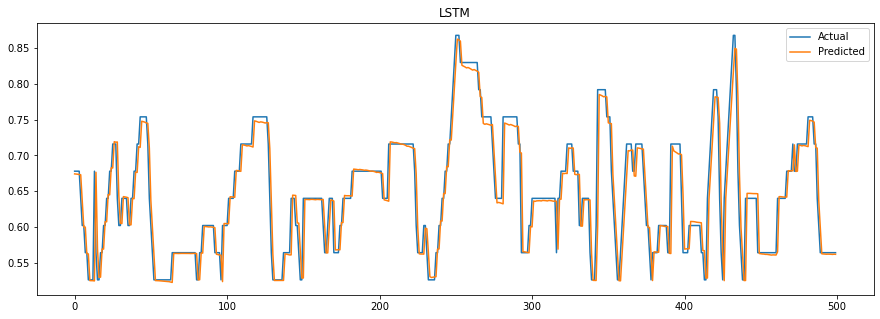

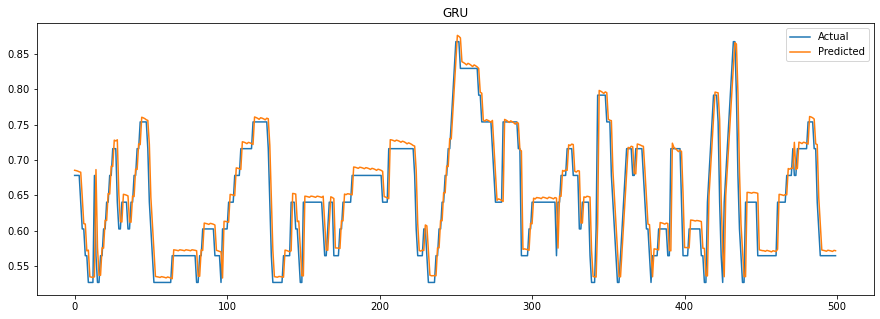

In [25]:
#LSTM over very small part of data
plt.plot(tes_lstm[:500], label = 'Actual')
plt.plot(fp_lstm[:500], label = 'Predicted')
plt.legend()
plt.title("LSTM")
plt.show()

#GRU over very small part of data
plt.plot(tes_Gru[:500], label = 'Actual')
plt.plot(fp_gru[:500], label = 'Predicted')
plt.legend()
plt.title("GRU")
plt.show()

## Conclusion:
We see that in case of our dataset LSTM works better than GRU, though both of them are RNN types , the key difference between GRU and LSTM is that GRU's bag has two gates that are reset and update while LSTM has three gates that are input, output, forget. GRU is less complex than LSTM because it has less number of gates. If the dataset is small then GRU is preferred otherwise LSTM for the larger dataset.